In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import sys

# custom imports
PROJECT_ROOT = Path(__file__).resolve().parent.parent if "__file__" in locals() else Path("../../..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.eval.evaluation.loader import load_test_data, load_model, reduce_mem_usage
from src.eval.evaluation.style import apply_shap_style, get_model_style, SHAP_BLUE
from src.features.scaler.Asinh1Scaler import StaticAsinh1Scaler

apply_shap_style()

In [2]:
DATA_PATH = Path("/Users/robin/PycharmProjects/Masterarbeit/data/parquet/features/asinh1-reg/splits")

TRAIN_FILE = DATA_PATH / "train.parquet"
TEST_FILE = DATA_PATH / "test_overlap.parquet"
VAL_FILE = DATA_PATH / "val_overlap.parquet"

COLS_OF_INTEREST = ["snapshot_times", "delivery_start", "label_5min", "bid_ask_spread", "orderbook_depth_imbalance"]

In [5]:
# read files
train_df = pd.read_parquet(TRAIN_FILE, columns=COLS_OF_INTEREST)
test_df = pd.read_parquet(TEST_FILE, columns=COLS_OF_INTEREST)
val_df = pd.read_parquet(VAL_FILE, columns=COLS_OF_INTEREST)

In [6]:
# basic statistics of the splits as dataframe
def get_split_stats(df, split_name):
    num_samples = len(df)
    label_mean = df["label_5min"].mean()
    label_std = df["label_5min"].std()
    return {
        "split": split_name,
        "Start Date": df["snapshot_times"].min(),
        "End Date": df["snapshot_times"].max(),
        "First Product": df["delivery_start"].min(),
        "Last Product": df["delivery_start"].max(),
        "Number of Observations": num_samples,
        "Number of Products": df["delivery_start"].nunique(),
        "Mean 5min Return": label_mean,
        "Standard Deviation": label_std,
        "5th Percentile": np.percentile(df["label_5min"], 5),
        "25th Percentile": np.percentile(df["label_5min"], 25),
        "50th Percentile": np.percentile(df["label_5min"], 50),
        "75th Percentile": np.percentile(df["label_5min"], 75),
        "95th Percentile": np.percentile(df["label_5min"], 95),
    }


all_samples = len(train_df) + len(test_df) + len(val_df)

stats_df = pd.DataFrame(columns=["Training Set", "Test Set", "Validation Set"])
train_stats = get_split_stats(train_df,
                              f"Training Set ({len(train_df) / all_samples:.2%})")
val_stats = get_split_stats(val_df, f"Validation Set ({len(val_df) / all_samples:.2%})")
test_stats = get_split_stats(test_df, f"Test Set ({len(test_df) / all_samples:.2%})")

sum_stats = get_split_stats(pd.concat([train_df, val_df, test_df]), "Summary")

stats_df = pd.DataFrame([train_stats, val_stats, test_stats, sum_stats]).set_index("split").T

stats_df

split,Training Set (67.67%),Validation Set (21.55%),Test Set (10.78%),Summary
Start Date,2023-02-28 19:30:00,2024-04-11 11:30:00,2024-08-04 06:30:30,2023-02-28 19:30:00
End Date,2024-04-11 14:50:00,2024-08-04 09:50:00,2024-09-30 20:50:00,2024-09-30 20:50:00
First Product,2023-03-01 00:00:00,2024-04-11 16:00:00,2024-08-04 11:00:00,2023-03-01 00:00:00
Last Product,2024-04-11 15:00:00,2024-08-04 10:00:00,2024-09-30 21:00:00,2024-09-30 21:00:00
Number of Observations,12579054,4005920,2003031,18588005
Number of Products,9644,2755,1379,13778
Mean 5min Return,0.000572,0.005963,-0.013841,0.000181
Standard Deviation,0.972762,1.080192,1.04061,0.994581
5th Percentile,-1.609294,-1.715104,-1.676232,-1.640133
25th Percentile,-0.632916,-0.705013,-0.690293,-0.654093


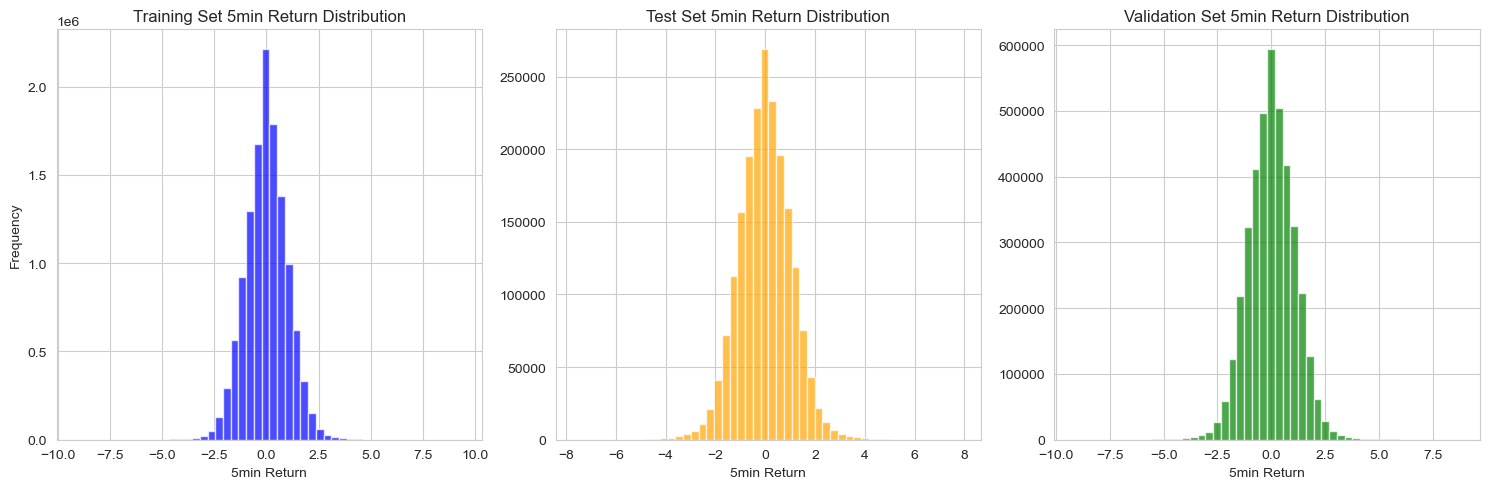

In [71]:
# Plot histograms of label_5min for each split
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(train_df["label_5min"], bins=50, color="blue", alpha=0.7)
plt.title("Training Set 5min Return Distribution")
plt.xlabel("5min Return")
plt.ylabel("Frequency")
plt.subplot(1, 3, 2)
plt.hist(test_df["label_5min"], bins=50, color="orange", alpha=0.7)
plt.title("Test Set 5min Return Distribution")
plt.xlabel("5min Return")
plt.subplot(1, 3, 3)
plt.hist(val_df["label_5min"], bins=50, color="green", alpha=0.7)
plt.title("Validation Set 5min Return Distribution")
plt.xlabel("5min Return")
plt.tight_layout()
plt.show()

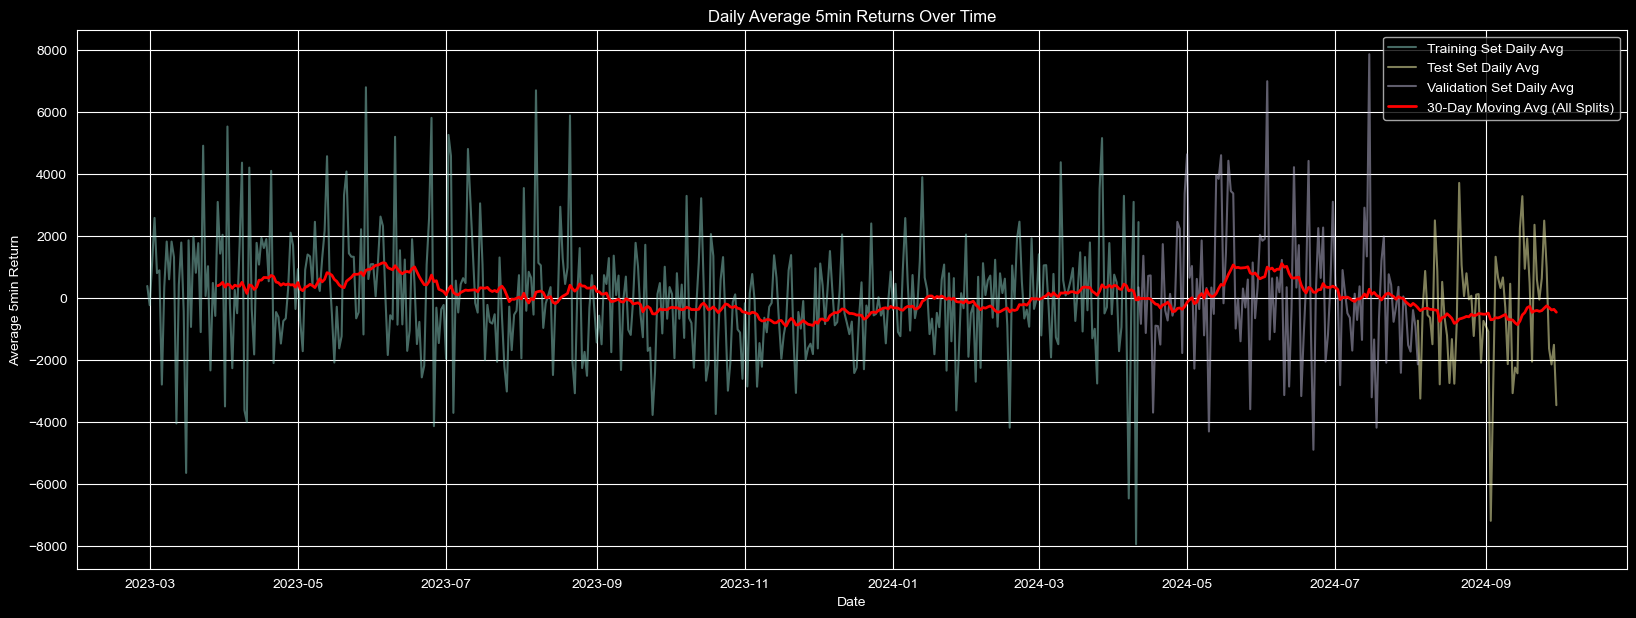

In [40]:
# check market movements over time in each split daily average of label_5min
train_daily = train_df.groupby(train_df["snapshot_times"].dt.date)["label_5min"].sum()
test_daily = test_df.groupby(test_df["snapshot_times"].dt.date)["label_5min"].sum()
val_daily = val_df.groupby(val_df["snapshot_times"].dt.date)["label_5min"].sum()

# 30-day moving average as one line over all splits
daily_all = pd.concat([train_daily, test_daily, val_daily])
daily_all.index = pd.to_datetime(daily_all.index)
daily_all = daily_all.sort_index()
daily_all_ma = daily_all.rolling(window=30).mean()

# plot daily averages and moving average
plt.figure(figsize=(20, 7))
plt.plot(train_daily.index, train_daily.values, label="Training Set Daily Avg", alpha=0.5)
plt.plot(test_daily.index, test_daily.values, label="Test Set Daily Avg", alpha=0.5)
plt.plot(val_daily.index, val_daily.values, label="Validation Set Daily Avg", alpha=0.5)
plt.plot(daily_all_ma.index, daily_all_ma.values, label="30-Day Moving Avg (All Splits)", color="red", linewidth=2)
plt.title("Daily Average 5min Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Average 5min Return")
plt.legend()
plt.show()


In [11]:
# df = pd.concat([train_df, test_df, val_df])
df = train_df

In [8]:
import joblib

# init scaler
SCALER_PATH = "/Users/robin/PycharmProjects/Masterarbeit/data/parquet/features/asinh1-reg/scaler/scaler.joblib"

scaler = joblib.load(SCALER_PATH)
ttd_col_name = scaler.ttd_col  # Meistens 'te_min_to_delivery'
print("Scaler geladen.")
print(f"TTD-Spaltenname im Scaler: {ttd_col_name}")
scaler.features_to_scale
print(dir(scaler))


Scaler geladen.
TTD-Spaltenname im Scaler: time_to_delivery_min
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__sklearn_clone__', '__sklearn_tags__', '__str__', '__subclasshook__', '__weakref__', '_doc_link_module', '_doc_link_template', '_doc_link_url_param_generator', '_get_class_level_metadata_request_values', '_get_doc_link', '_get_metadata_request', '_get_param_names', '_get_params_html', '_html_repr', '_merge_profiles', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_sklearn_auto_wrap_output_keys', '_validate_params', 'epsilon', 'features_to_scale', 'fit', 'fit_transform', 'get_metadata_routing', 'get_params', 'inverse_transform', 'load', 'mad_factor_', 'profile_df_', 'save', 'set_inverse_